In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

## Исследуем датасеты

### 1 olist_customers_dataset

In [2]:
customers = pd.read_csv('data/olist_customers_dataset.csv')
customers.shape

(99441, 5)

In [3]:
"""
customer_id	 - id покупки 
customerunique_id - id покупателя
customer_zip_code_prefix - позволяет подтянуть широту и долготу
"""
customers.head(5)

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

In [4]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [5]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
""" Удалим лишнее """
customers = customers.drop('customer_unique_id', axis=1)

### 2 olist_geolocation_dataset

In [7]:
geo = pd.read_csv('data/olist_geolocation_dataset.csv')
geo.shape

(1000163, 5)

In [8]:
geo.head(5)

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

In [9]:
"""
тут странность, связное поле, через которое можно смерджить данные имеет разные показатели широты и долготы
"""

geo.nunique()

geolocation_zip_code_prefix     19015
geolocation_lat                717360
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64

In [10]:
"""
пример:
"""

geo[geo.geolocation_zip_code_prefix == 1037].head(5)

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                           1037       -23.545621       -46.639292   
14                          1037       -23.545187       -46.637855   
31                          1037       -23.546705       -46.640336   
169                         1037       -23.543883       -46.638075   
178                         1037       -23.546157       -46.639885   

    geolocation_city geolocation_state  
0          sao paulo                SP  
14         são paulo                SP  
31         são paulo                SP  
169        são paulo                SP  
178        sao paulo                SP

In [11]:
"""
Чтобы убрать разбег по широте/долготе, усредним их в рамках одного зип кода
Отсальные поля нам не нужны (в более чистом виде есть в датасете customer)

Переименуем столбец zip кодов для быстрого мерджа
"""

geo = geo.groupby('geolocation_zip_code_prefix', 
            as_index=False).agg({'geolocation_lat': 'mean', 
                                 'geolocation_lng': 'mean'
                                })
geo.columns = ['customer_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']
geo.head()

customer_zip_code_prefix  geolocation_lat  geolocation_lng
0                      1001       -23.550190       -46.634024
1                      1002       -23.548146       -46.634979
2                      1003       -23.548994       -46.635731
3                      1004       -23.549799       -46.634757
4                      1005       -23.549456       -46.636733

### 3 olist_order_items_dataset

In [12]:
items = pd.read_csv('data/olist_order_items_dataset.csv')
items.shape

(112650, 7)

In [13]:
"""
отсюда взять кол-во товаров в заказе и product_id, остальное не нужно
"""

items.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

In [14]:
"""
order_item_id агрегировать по count()
в примере видим счетчик:
"""

items[items.order_id == '00143d0f86d6fbd9f9b38ab440ac16f5']

order_id  order_item_id  \
32  00143d0f86d6fbd9f9b38ab440ac16f5              1   
33  00143d0f86d6fbd9f9b38ab440ac16f5              2   
34  00143d0f86d6fbd9f9b38ab440ac16f5              3   

                          product_id                         seller_id  \
32  e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
33  e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
34  e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   

    shipping_limit_date  price  freight_value  
32  2017-10-20 16:07:52  21.33           15.1  
33  2017-10-20 16:07:52  21.33           15.1  
34  2017-10-20 16:07:52  21.33           15.1

In [15]:
"""
Удалим лишнее и преобразуем имя order_item_id в кол-во товаров в заказе
"""

items = items.drop(['seller_id',
       'shipping_limit_date', 'price', 'freight_value'], axis=1)

items = items.groupby(['order_id', 'product_id'], as_index = False).agg({'order_item_id': 'count'})
items.columns = ['order_id', 'product_id', 'order_items_quant']
items.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

   order_items_quant  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1

### 4 olist_order_payments_dataset

In [16]:
payments = pd.read_csv('data/olist_order_payments_dataset.csv')
payments.shape

(103886, 5)

In [17]:
"""
возможно, интересна сумма, если нет в другом месте
payment_type - карточки и предварит контракт boleto( не знаю, что это, вероятно оплата по счету)
payment_sequential и payment_installments тоже непонятно
"""

payments.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

In [18]:
payments.nunique()

order_id                99440
payment_sequential         29
payment_type                5
payment_installments       24
payment_value           29077
dtype: int64

In [19]:
"""
Удалим лишнее
"""
payments = payments.drop(['payment_sequential', 'payment_type',
       'payment_installments'], axis=1)
payments.head()

order_id  payment_value
0  b81ef226f3fe1789b1e8b2acac839d17          99.33
1  a9810da82917af2d9aefd1278f1dcfa0          24.39
2  25e8ea4e93396b6fa0d3dd708e76c1bd          65.71
3  ba78997921bbcdc1373bb41e913ab953         107.78
4  42fdf880ba16b47b59251dd489d4441a         128.45

### 5 olist_order_reviews_dataset

In [20]:
reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
reviews.shape

(99224, 7)

In [21]:
"""
МОжно было бы дополнительно построить зависимость скора отзыва от погоды во время его написания
Но как будто это уже через чур
Поэтому исключим эти данные из рассмотрения как лишние
"""

reviews.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

### 6 olist_orders_dataset

In [22]:
orders = pd.read_csv('data/olist_orders_dataset.csv')
orders.shape

(99441, 8)

In [23]:
"""
Удалить все кроме order_id, customer_id, order_purchase_timestamp
Расшифровка дальше
"""

orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

In [24]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [25]:
"""
Возможно, стоит удалить canceled         625
Но на таком объеме кажется непринципиальным, проще просто удалить признак
"""

orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [26]:
"""
Удаляем лишнее
"""
orders = orders.drop(['order_status',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'], axis=1)
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_purchase_timestamp  
0      2017-10-02 10:56:33  
1      2018-07-24 20:41:37  
2      2018-08-08 08:38:49  
3      2017-11-18 19:28:06  
4      2018-02-13 21:18:39

### 7 olist_products_dataset

In [27]:
products = pd.read_csv('data/olist_products_dataset.csv')
products.shape

(32951, 9)

In [28]:
"""
Удалить все кроме product_id и product_category_name
product_category_name - поменять на английский 

"""

products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [29]:
"""
Удаляем лишнее
"""
products = products.drop(['product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'], axis=1)
products.head()

product_id  product_category_name
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer
3  cef67bcfe19066a932b7673e239eb23d                  bebes
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas

In [30]:
products.isnull().sum()

product_id                 0
product_category_name    610
dtype: int64

In [31]:
"""
Заполним пустышки значением unknown
"""

products = products.fillna('unknown')

In [32]:
"""
Подгрузим справочник переводов категорий
Далее сольем его с products и оставим английские названия
"""
product_category_name = pd.read_csv('data/product_category_name_translation.csv')
product_category_name.shape

(71, 2)

In [33]:
product_category_name.head()

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

In [34]:
products = products.merge(product_category_name,
              on='product_category_name',
              how='left')
products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

  product_category_name_english  
0                     perfumery  
1                           art  
2                sports_leisure  
3                          baby  
4                    housewares

In [35]:
"""
Не все переводы в наличии
"""

products.isnull().sum()

product_id                         0
product_category_name              0
product_category_name_english    623
dtype: int64

In [36]:
products[products.product_category_name_english.isnull() == True].product_category_name.value_counts()

unknown                                          610
portateis_cozinha_e_preparadores_de_alimentos     10
pc_gamer                                           3
Name: product_category_name, dtype: int64

In [37]:
"""
Присвоим пустым значениям значения на португальском, переведем на английский
"""
products.loc[(products.product_category_name_english.isnull() == True), 'product_category_name_english'] = \
    products.loc[(products.product_category_name_english.isnull() == True), 'product_category_name']
products.loc[(products.product_category_name_english == 'portateis_cozinha_e_preparadores_de_alimentos'), 
             'product_category_name_english'] = 'kitchen_cooking_furniture'

In [38]:
"""
Удалим лишнюю колонку, получим финальный датасет 
"""
products = products.drop('product_category_name', axis=1)
products.head()

product_id product_category_name_english
0  1e9e8ef04dbcff4541ed26657ea517e5                     perfumery
1  3aa071139cb16b67ca9e5dea641aaa2f                           art
2  96bd76ec8810374ed1b65e291975717f                sports_leisure
3  cef67bcfe19066a932b7673e239eb23d                          baby
4  9dc1a7de274444849c219cff195d0b71                    housewares

### 8 olist_sellers_dataset

In [39]:
sellers = pd.read_csv('data/olist_sellers_dataset.csv')
sellers.shape

(3095, 4)

In [40]:
"""
Здесь полезных данных нет, его не используем
"""
sellers.head()

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

### 9 Объединяем все полезные фичи в единый датасет

In [41]:
"""
Проверяем, какие фичи остались
"""
full_list = list(customers.columns) + list(geo.columns) + list(items.columns) + list(payments.columns) +list(orders.columns) + list(products.columns)
dic = {}
for i in full_list:
    dic[i] = dic.get(i, 0) + 1
dic

{'customer_id': 2,
 'customer_zip_code_prefix': 2,
 'customer_city': 1,
 'customer_state': 1,
 'geolocation_lat': 1,
 'geolocation_lng': 1,
 'order_id': 3,
 'product_id': 2,
 'order_items_quant': 1,
 'payment_value': 1,
 'order_purchase_timestamp': 1,
 'product_category_name_english': 1}

In [42]:
"""
Cлить по порядку:
1) customers и geo
2) items и products
3) orders и payments
4) orders и customers
5) orders и items

6) Удалить артефактные столбцы
"""

'\nCлить по порядку:\n1) customers и geo\n2) items и products\n3) orders и payments\n4) orders и customers\n5) orders и items\n\n6) Удалить артефактные столбцы\n'

In [43]:
"""
1) Объединяем customers и geo
"""
customers = customers.merge(geo,
              on='customer_zip_code_prefix',
              how='left')

In [44]:
customers.isnull().sum()

customer_id                   0
customer_zip_code_prefix      0
customer_city                 0
customer_state                0
geolocation_lat             278
geolocation_lng             278
dtype: int64

In [45]:
"""
Восстановим долготу и широту по среднегородской
"""

city_lst = list(customers.loc[(customers.geolocation_lat.isnull() == True)].customer_city.unique())
for city in city_lst:
    customers.loc[(customers.customer_city == city) & (customers.geolocation_lat.isnull() == True), 'geolocation_lat'] = \
        customers.loc[customers.customer_city == city].geolocation_lat.mean()
    customers.loc[(customers.customer_city == city) & (customers.geolocation_lng.isnull() == True), 'geolocation_lng'] = \
        customers.loc[customers.customer_city == city].geolocation_lng.mean()    
customers.isnull().sum()

customer_id                  0
customer_zip_code_prefix     0
customer_city                0
customer_state               0
geolocation_lat             52
geolocation_lng             52
dtype: int64

In [46]:
"""
Оставшихся городов не оказалось в системе, удалим их, 
поскольку усреднение в рамках штата может сделать прогноз неадекватным
"""
customers = customers.dropna(how='any', axis=0)
customers.head()

customer_id  customer_zip_code_prefix  \
0  06b8999e2fba1a1fbc88172c00ba8bc7                     14409   
1  18955e83d337fd6b2def6b18a428ac77                      9790   
2  4e7b3e00288586ebd08712fdd0374a03                      1151   
3  b2b6027bc5c5109e529d4dc6358b12c3                      8775   
4  4f2d8ab171c80ec8364f7c12e35b23ad                     13056   

           customer_city customer_state  geolocation_lat  geolocation_lng  
0                 franca             SP       -20.498489       -47.396929  
1  sao bernardo do campo             SP       -23.727992       -46.542848  
2              sao paulo             SP       -23.531642       -46.656289  
3        mogi das cruzes             SP       -23.499702       -46.185233  
4               campinas             SP       -22.975100       -47.142925

In [47]:
"""
2) Объединяем items и products
"""
items = items.merge(products,
              on='product_id',
              how='left')

items.isnull().sum()

order_id                         0
product_id                       0
order_items_quant                0
product_category_name_english    0
dtype: int64

In [48]:
"""
3) Объединяем orders и payments
"""
orders = orders.merge(payments,
              on='order_id',
              how='left')
orders.isnull().sum()

order_id                    0
customer_id                 0
order_purchase_timestamp    0
payment_value               1
dtype: int64

In [49]:
"""
Заполним средним значением пропущенную сумму
"""
orders['payment_value'] = orders['payment_value'].fillna(orders.payment_value.mean())
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_purchase_timestamp  payment_value  
0      2017-10-02 10:56:33          18.12  
1      2017-10-02 10:56:33           2.00  
2      2017-10-02 10:56:33          18.59  
3      2018-07-24 20:41:37         141.46  
4      2018-08-08 08:38:49         179.12

In [50]:
"""
4) Объединяем orders и customers
"""
orders = orders.merge(customers,
            on='customer_id',
            how='left')
orders.isnull().sum()

order_id                     0
customer_id                  0
order_purchase_timestamp     0
payment_value                0
customer_zip_code_prefix    53
customer_city               53
customer_state              53
geolocation_lat             53
geolocation_lng             53
dtype: int64

In [51]:
"""
Удалим строки, где отсутствуют данные по координатам,
поскольку эти данные для нас критичны
"""
orders = orders.dropna(how='any', axis=0)
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_purchase_timestamp  payment_value  customer_zip_code_prefix  \
0      2017-10-02 10:56:33          18.12                    3149.0   
1      2017-10-02 10:56:33           2.00                    3149.0   
2      2017-10-02 10:56:33          18.59                    3149.0   
3      2018-07-24 20:41:37         141.46                   47813.0   
4      2018-08-08 08:38:49         179.12                   75265.0   

  customer_city customer_state  geolocation_lat  geolocation_lng  
0     sao paulo             SP       -23.576983       -46.587161  
1     sao paulo             SP       -23.576983       -46.587161  
2     sao paulo             SP       -23.576983       -46.587161  
3     barreiras             BA       -12.177924       -44.660711  
4    vianopolis             GO       -16.745150       -48.514783

In [52]:
"""
5) Объединяем orders и customers
"""
orders = orders.merge(items,
            on='order_id',
            how='left')
orders.isnull().sum()

order_id                           0
customer_id                        0
order_purchase_timestamp           0
payment_value                      0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
geolocation_lat                    0
geolocation_lng                    0
product_id                       829
order_items_quant                829
product_category_name_english    829
dtype: int64

In [53]:
"""
Заполним пустые строки значением 'unknown'
"""
orders['order_items_quant'] = orders['order_items_quant'].fillna(1)
orders = orders.fillna('unknown')
orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_purchase_timestamp  payment_value  customer_zip_code_prefix  \
0      2017-10-02 10:56:33          18.12                    3149.0   
1      2017-10-02 10:56:33           2.00                    3149.0   
2      2017-10-02 10:56:33          18.59                    3149.0   
3      2018-07-24 20:41:37         141.46                   47813.0   
4      2018-08-08 08:38:49         179.12                   75265.0   

  customer_city customer_state  geolocation_lat  geolocation_lng  \
0     sao paulo             SP       -23.576983       -46.587161   
1     sao paulo             SP       -23.576983       -46.587161   
2     sao paulo             SP       -23.576983       -46.587161   
3     barreiras             BA       -12.177924       -44.660711   
4    vianopolis             GO       -16.745150       -48.514783   

                         product_id  order_items_quant  \
0  87285b34884572647811a353c7ac498a                1.0   
1  87285b34884572647811a353c7ac498a                1.0   
2  87285b34884572647811a353c7ac498a                1.0   
3  595fac2a385ac33a80bd5114aec74eb8                1.0   
4  aa4383b373c6aca5d8797843e5594415                1.0   

  product_category_name_english  
0                    housewares  
1                    housewares  
2                    housewares  
3                     perfumery  
4                          auto

In [54]:
"""
6) Удалим артефакты, переименуем признаки для удобства
"""
orders = orders.drop(['order_id', 'customer_id', 'product_id'], axis=1)

orders.columns = ['timestamp', 'payment_value', 'zip_code',
       'city', 'state', 'latitude', 'longitude',
       'items_quant', 'product_category']

orders.head()

timestamp  payment_value  zip_code        city state   latitude  \
0  2017-10-02 10:56:33          18.12    3149.0   sao paulo    SP -23.576983   
1  2017-10-02 10:56:33           2.00    3149.0   sao paulo    SP -23.576983   
2  2017-10-02 10:56:33          18.59    3149.0   sao paulo    SP -23.576983   
3  2018-07-24 20:41:37         141.46   47813.0   barreiras    BA -12.177924   
4  2018-08-08 08:38:49         179.12   75265.0  vianopolis    GO -16.745150   

   longitude  items_quant product_category  
0 -46.587161          1.0       housewares  
1 -46.587161          1.0       housewares  
2 -46.587161          1.0       housewares  
3 -44.660711          1.0        perfumery  
4 -48.514783          1.0             auto

In [55]:
orders.shape

(107802, 9)

### 10 Добавим метеоданные

In [56]:
"""
Дополним наш датасет метеоданными
"""
# orders.to_csv('orders.csv', index=False) # выгрузка и дополнение метеоданными производятся в ноутбуке Parse_Meteo.ipynb
orders = pd.read_csv('data/orders_with_meteo.csv')
orders.shape

(107802, 37)

In [57]:
"""
ПРоверим качество дополненных данных
"""
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107802 entries, 0 to 107801
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     107802 non-null  int64  
 1   timestamp                      107802 non-null  object 
 2   payment_value                  107802 non-null  float64
 3   zip_code                       107802 non-null  float64
 4   city                           107802 non-null  object 
 5   state                          107802 non-null  object 
 6   latitude                       107802 non-null  float64
 7   longitude                      107802 non-null  float64
 8   items_quant                    107802 non-null  float64
 9   product_category               107802 non-null  object 
 10  date                           107802 non-null  object 
 11  time                           107802 non-null  object 
 12  weekday                       

In [58]:
pd.set_option('display.max_columns', 50)
orders.head()

Unnamed: 0            timestamp  payment_value  zip_code        city state  \
0           0  2017-10-02 10:56:33          18.12    3149.0   sao paulo    SP   
1           1  2017-10-02 10:56:33           2.00    3149.0   sao paulo    SP   
2           2  2017-10-02 10:56:33          18.59    3149.0   sao paulo    SP   
3           3  2018-07-24 20:41:37         141.46   47813.0   barreiras    BA   
4           4  2018-08-08 08:38:49         179.12   75265.0  vianopolis    GO   

    latitude  longitude  items_quant product_category        date      time  \
0 -23.576983 -46.587161          1.0       housewares  2017-10-02  10:56:33   
1 -23.576983 -46.587161          1.0       housewares  2017-10-02  10:56:33   
2 -23.576983 -46.587161          1.0       housewares  2017-10-02  10:56:33   
3 -12.177924 -44.660711          1.0        perfumery  2018-07-24  20:41:37   
4 -16.745150 -48.514783          1.0             auto  2018-08-08  08:38:49   

     weekday  apparent_temperature_max  apparent_temperature_min  \
0     Monday                      22.9                      19.1   
1     Monday                      22.9                      19.1   
2     Monday                      22.9                      19.1   
3    Tuesday                      32.8                      18.5   
4  Wednesday                      33.3                      20.4   

   et0_fao_evapotranspiration  precipitation_hours  precipitation_sum  \
0                        2.49                  5.0                2.3   
1                        2.49                  5.0                2.3   
2                        2.49                  5.0                2.3   
3                        4.74                  0.0                0.0   
4                        4.28                  0.0                0.0   

   rain_sum  snowfall_sum           sunrise            sunset  weathercode  \
0       2.3           0.0  2017-10-02T05:44  2017-10-02T18:07         53.0   
1       2.3           0.0  2017-10-02T05:44  2017-10-02T18:07         53.0   
2       2.3           0.0  2017-10-02T05:44  2017-10-02T18:07         53.0   
3       0.0           0.0  2018-07-24T06:18  2018-07-24T17:52          1.0   
4       0.0           0.0  2018-08-08T06:34  2018-08-08T18:04          1.0   

   winddirection_10m_dominant  windgusts_10m_max  windspeed_10m_max  \
0                       335.0               65.2               23.1   
1                       335.0               65.2               23.1   
2                       335.0               65.2               23.1   
3                       125.0               31.0               12.9   
4                        68.0               38.5               15.0   

   cloud_cover_total_mean_%  cloudcover_high_mean_%  cloudcover_low_mean_%  \
0                 84.083333               84.833333              32.416667   
1                 84.083333               84.833333              32.416667   
2                 84.083333               84.833333              32.416667   
3                 16.666667                0.000000               0.250000   
4                 18.583333               32.750000               0.000000   

   cloudcover_mid_mean_%  surface_pressure_mean_hPa  temperature_2m_max  \
0              73.333333                 919.850000                22.3   
1              73.333333                 919.850000                22.3   
2              73.333333                 919.850000                22.3   
3              27.250000                 959.941667                31.4   
4              14.583333                 928.075000                32.3   

   temperature_2m_min  temperature_2m_hourly  precipitation_hourly  \
0                19.2                   20.7                   0.0   
1                19.2                   20.7                   0.0   
2                19.2                   20.7                   0.0   
3                18.6                   25.4                   0.0   
4                20.1      

In [59]:
"""
Удалим первую колонку индекса
"""
orders = orders.drop('Unnamed: 0', axis=1)

In [60]:
"""
Посчитаем продолжительность дня из колонок sunrise и sunset, удалим лишние колонки
"""
orders['daylight_hours'] = orders.sunset.apply(lambda x: pd.to_datetime(x.split('T')[1])) - \
    orders.sunrise.apply(lambda x: pd.to_datetime(x.split('T')[1]))
orders['daylight_minuites'] = orders['daylight_hours'].apply(lambda x: x.seconds/60)
orders = orders.drop(['sunrise', 'sunset', 'daylight_hours'], axis=1)

In [61]:
"""
Посмотрим кол-во снежных дней за период
Всего таких 2 дня, это слишком мало, чтобы делать какие-то выводы
"""
orders[orders.snowfall_sum > 0]

timestamp  payment_value  zip_code            city state  \
70055  2017-07-18 17:45:54          70.74   88650.0         urubici    SC   
72824  2017-07-17 09:09:48         149.04   88750.0  braco do norte    SC   

        latitude  longitude  items_quant       product_category        date  \
70055 -28.002167 -49.586858          1.0  computers_accessories  2017-07-18   
72824 -28.274305 -49.165212          1.0         sports_leisure  2017-07-17   

           time  weekday  apparent_temperature_max  apparent_temperature_min  \
70055  17:45:54  Tuesday                       8.3                      -6.5   
72824  09:09:48   Monday                      12.7                      -2.2   

       et0_fao_evapotranspiration  precipitation_hours  precipitation_sum  \
70055                        1.85                  2.0                0.7   
72824                        0.26                 21.0               27.1   

       rain_sum  snowfall_sum  weathercode  winddirection_10m_dominant  \
70055       0.6          0.07         71.0                       200.0   
72824      25.3          1.26         73.0                       183.0   

       windgusts_10m_max  windspeed_10m_max  cloud_cover_total_mean_%  \
70055               23.0                9.0                       0.0   
72824               26.6                8.5                     100.0   

       cloudcover_high_mean_%  cloudcover_low_mean_%  cloudcover_mid_mean_%  \
70055                     0.0                    0.0                    0.0   
72824                     0.0                  100.0                  100.0   

       surface_pressure_mean_hPa  temperature_2m_max  temperature_2m_min  \
70055                 922.783333                10.6                -2.5   
72824                 899.800000                12.8                 0.9   

       temperature_2m_hourly  precipitation_hourly  \
70055                    9.4                   0.0   
72824                    7.7                   1.4   

       relative_humidity_2m_hourly  daily_shortwave_radiation_sum  \
70055                         49.0                          15.29   
72824                         99.0                           1.01   

       daylight_minuites  
70055              637.0  
72824              635.0

In [62]:
"""
Поэтому удалим признак snowfall_sum, а также rain_sum, потому что есть 
суммирующий осадки столбец precipitation_sum
"""
orders = orders.drop(['snowfall_sum', 'rain_sum'], axis=1)

In [63]:
#pd.DataFrame(orders[(orders.date > datetime(2017, 7, 1).date()) & 
#                    (orders.date < datetime(2017, 7, 31).date())]
#             .groupby('date').payment_value.sum()).reset_index()

### 11 Разберемся с временным рядом

In [64]:
"""
Пока непонятна история с часовыми поясами,
нужно проверить, что время указано адекватно,
поскольку эта информация отсутствует в описании датасета
"""
orders.timestamp = pd.to_datetime(orders.timestamp)

In [65]:
"""
Добавим новые слолбцы datetime для дальнейшего анализа
"""
orders['date'] = orders.timestamp.dt.date
orders['month'] = orders.timestamp.dt.month
orders['time'] = orders.timestamp.dt.time
orders['weekday'] = orders.timestamp.dt.day_name()

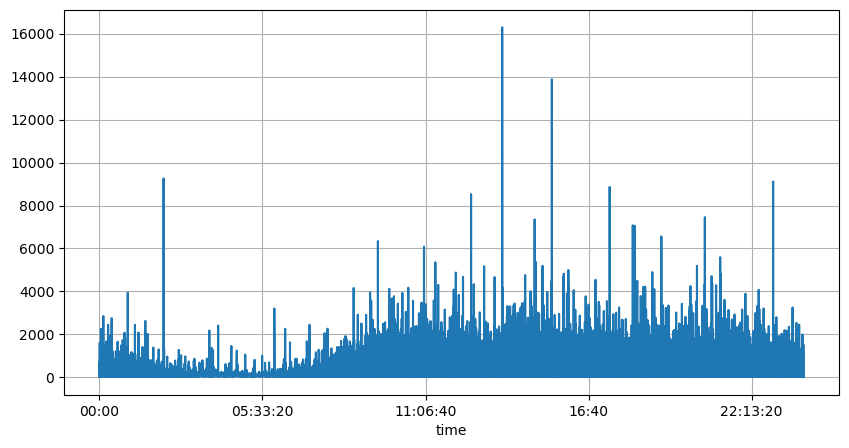

In [66]:
"""
График суточной активности вполне соответствует норме
Можно заключить, что время приведено к местному
"""
orders.groupby('time').payment_value.sum().plot(kind='line', figsize=(10,5), grid=True);

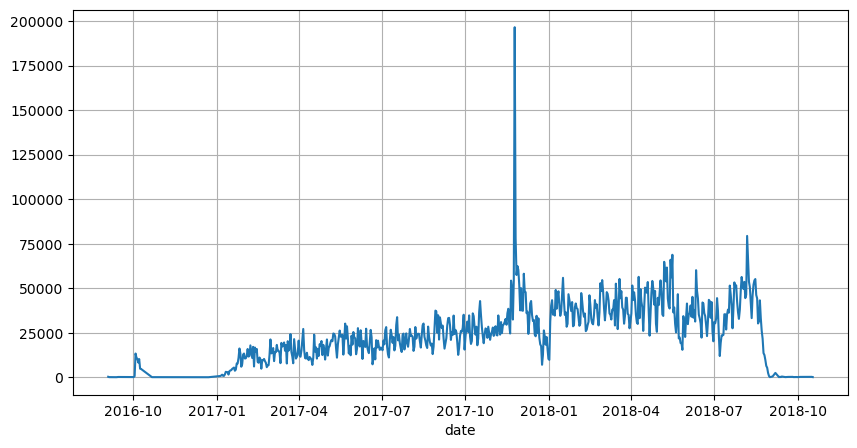

In [67]:
"""
График продаж по дням
Есть странная аномалия в конце 2017 года, надо проверить, нет ли ошибки в данных
Также график ведет себя странно на хвостах, возможно, их надо отсечь
"""
orders.groupby('date').payment_value.sum().plot(kind='line', figsize=(10,5), grid=True);

In [68]:
"""
Аномалия приходится на 2017-11-24
Похоже на "черную пятнцицу"
"""
orders.groupby('date').payment_value.sum().sort_values(ascending=False).head(3)

date
2017-11-24    196614.09
2018-08-06     79389.61
2017-11-25     78268.33
Name: payment_value, dtype: float64

In [69]:
"""
Посмотрим все продажи за этот день
"""
orders[orders.date == datetime(2017, 11, 24).date()].payment_value.describe()

count    1283.000000
mean      153.245588
std       242.586763
min         0.080000
25%        57.585000
50%        96.220000
75%       171.515000
max      6081.540000
Name: payment_value, dtype: float64

In [70]:
"""
Хотя мы видим одну выделяющуюся покупку, она явно неспособна исказить данные
"""
orders[orders.date == datetime(2017, 11, 24).date()].payment_value.sort_values(ascending=False).head(3)

35084    6081.54
58384    2429.68
62562    1798.01
Name: payment_value, dtype: float64

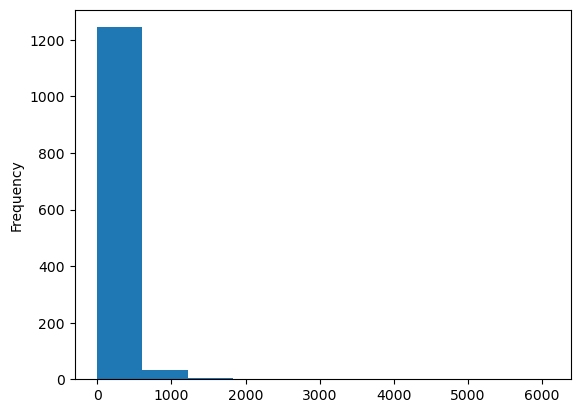

In [71]:
"""
Построим гистограмму распеределения трат 24 ноября 2017
Мы видим много мелких покупок, проверим их
"""
orders[orders.date == datetime(2017, 11, 24).date()].payment_value.plot(kind='hist');

In [72]:
"""
Число одинаковых мелких покупок выглядит адекватным
Можем заключить, что в данных нет ошибок и речь идет именно о "черной пятнице"
"""
orders[orders.date == datetime(2017, 11, 24).date()].payment_value.value_counts().head(5)

66.67     24
66.64     11
168.36     6
62.44      6
30.00      6
Name: payment_value, dtype: int64

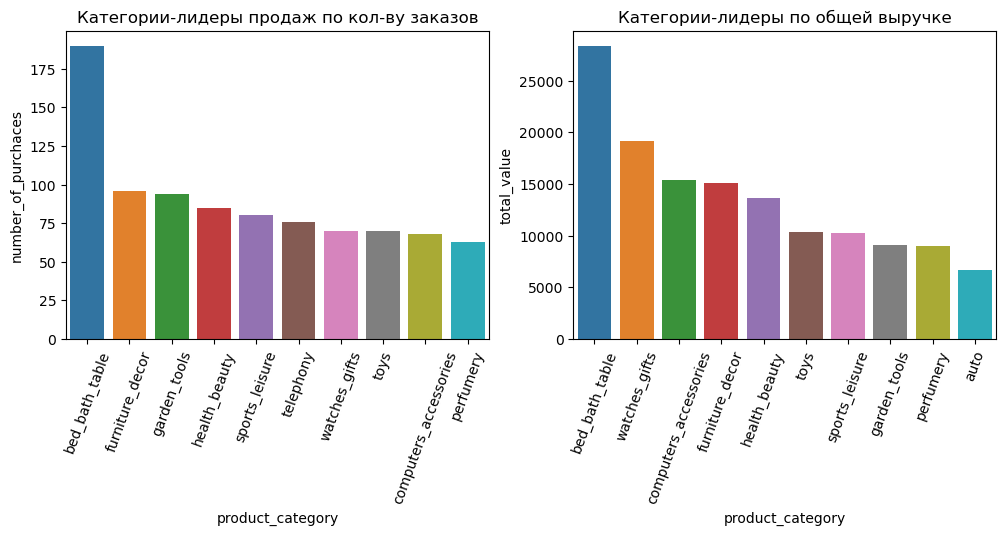

In [73]:
"""
Полюбопытствуем, что люди покупали на черную пятницу:

В лидерах категории:
 - товары для дома и сада
 - подарки
 - косметика и товары для здоровья
 - спорттовары
 - компьютерные аксессуары
 - игрушки
 - телефоны и акусессуары
 
"""

bf_product_cat_purch_num = pd.DataFrame({'number_of_purchaces': orders[orders.date == datetime(2017, 11, 24).date()].
                                     groupby('product_category').payment_value.count(),
                                     'total_value': orders[orders.date == datetime(2017, 11, 24).date()].
                                     groupby('product_category').payment_value.sum()
                                    },
                                   ).sort_values(by='number_of_purchaces', ascending=False).head(10)

bf_product_cat_sums = pd.DataFrame({'number_of_purchaces': orders[orders.date == datetime(2017, 11, 24).date()].
                                     groupby('product_category').payment_value.count(),
                                     'total_value': orders[orders.date == datetime(2017, 11, 24).date()].
                                     groupby('product_category').payment_value.sum()
                                    },
                                   ).sort_values(by='total_value', ascending=False).head(10)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes0 = sns.barplot(
    data=bf_product_cat_purch_num,
    x=bf_product_cat_purch_num.index,
    y='number_of_purchaces',
    orient='v',
    ax = axes[0]
);
axes0.set_title('Категории-лидеры продаж по кол-ву заказов')
axes0.tick_params(axis='x', rotation=70);

axes1 = sns.barplot(
    data=bf_product_cat_sums,
    x=bf_product_cat_sums.index,
    y='total_value',
    orient='v',
    ax = axes[1]
);
axes1.tick_params(axis='x', rotation=70);
axes1.set_title('Категории-лидеры по общей выручке');

In [74]:
"""
А теперь удалим этот день из наблюдений, как выброс
"""
index_24_11_17_lst = list(orders[orders.date == datetime(2017, 11, 24).date()].index)
orders = orders.drop(index_24_11_17_lst, axis=0)

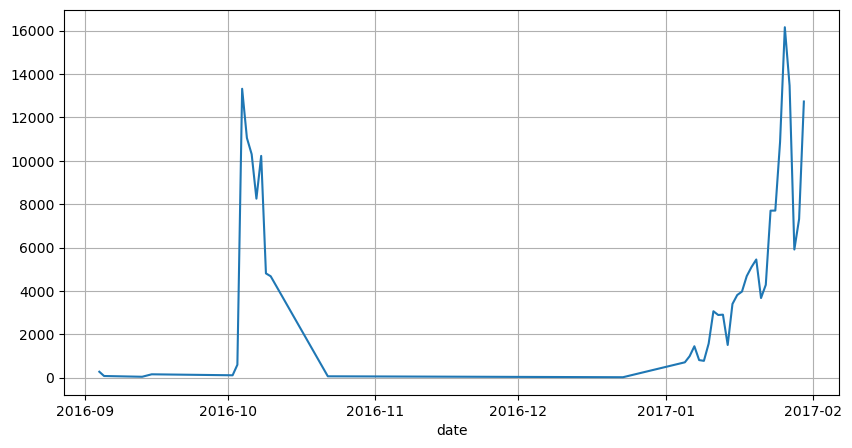

In [75]:
"""
Теперь проверим, что с "хвостами"
Графики демонстрируют явно аномальное поведение, возможно система учета продаж была включена 
в тестовом режиме в коце 2016 года, и только в конце января 2017 года выведена в продакшн

"""
orders[orders.date < datetime(2017, 1, 31).date()]. \
    groupby('date').payment_value.sum().plot(kind='line', figsize=(10,5), grid=True);

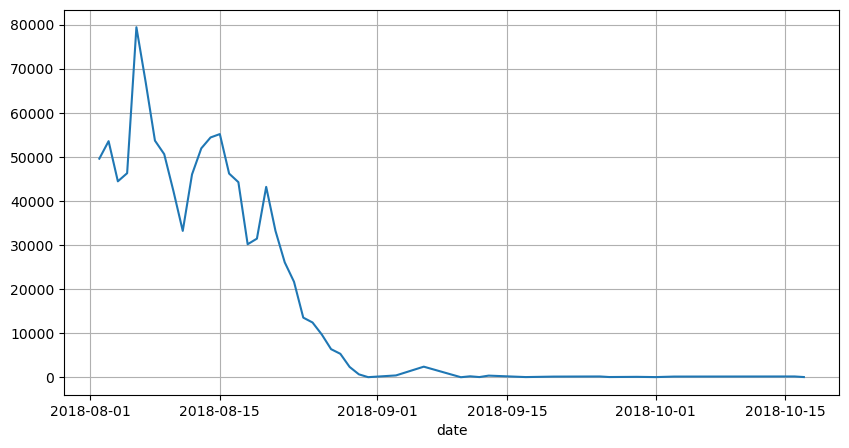

In [76]:
"""
Со 2-й половины августа 2018года мы видим постепенное прекращение получения данных системой учета
"""

orders[orders.date > datetime(2018, 8, 1).date()]. \
    groupby('date').payment_value.sum().plot(kind='line', figsize=(10,5), grid=True);

In [77]:
"""
Построим дополнительно интерактивный график для возможности масштабирования
"""
import plotly
import plotly.express as px
line_data = pd.DataFrame(orders.groupby('date').payment_value.sum()).reset_index()
fig = px.line(
    data_frame=line_data, #DataFrame
    x='date', #ось абсцисс
    y='payment_value', #ось ординат
    height=500, #высота
    width=1000, #ширина
#    title='Confirmed, Recovered, Deaths, Active cases over Time' #заголовок
)
fig.show()

In [78]:
"""
"Отрежем" аномальные хвосты:
- до 25.01.2017
- после 20.08.2018
"""
tails_index_lst = orders[(orders.date > datetime(2018, 8, 20).date()) | 
                         (orders.date < datetime(2017, 1, 25).date())].index
orders = orders.drop(tails_index_lst, axis=0)

In [79]:
"""
Удалим лишние признаки:
latitude
longitude
winddirection_10m_dominant
"""
orders = orders.drop(['latitude', 'longitude', 'winddirection_10m_dominant'], axis=1)

### 12 Уберем влияние других факторов

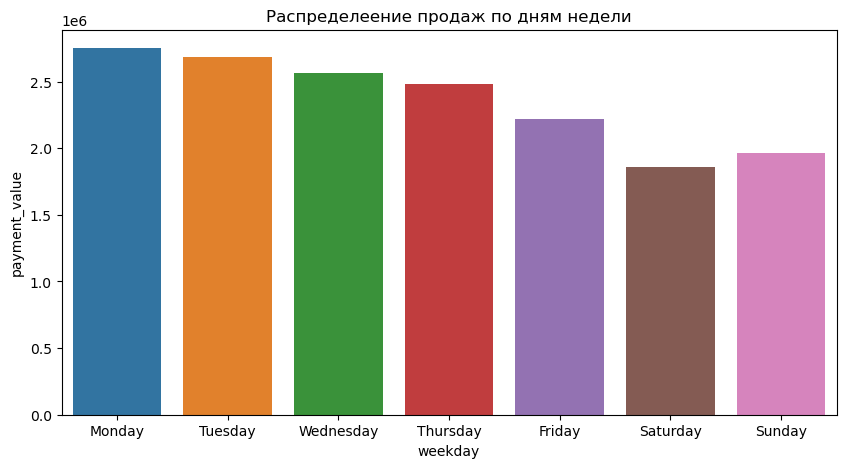

In [80]:
"""
Сгруппируем данные продаж по дням недели
"""
fig, axes = plt.subplots(figsize=(10, 5))
weekday_payments = pd.DataFrame(orders.groupby('weekday').payment_value.sum()).reset_index()
weekdays_bar = sns.barplot(weekday_payments,
           x='weekday',
           y='payment_value',
           order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
;
weekdays_bar.set_title('Распределеение продаж по дням недели');

In [81]:
"""
Очевидно, что продажи имеют сильную зависимость от дня недели.
Для нивелирования влияния дней недели на параметр продаж, введем веса
Для этого посчитаем долю дня недели в недельной структуре продаж
Разделим продажи соответствующего дня недели на его долю
"""
weekday_payments['weekday_share'] = weekday_payments.payment_value / weekday_payments.payment_value.sum()
weekday_payments

weekday  payment_value  weekday_share
0     Friday     2219786.26       0.134335
1     Monday     2751579.89       0.166518
2   Saturday     1858639.24       0.112479
3     Sunday     1964673.61       0.118896
4   Thursday     2484142.54       0.150333
5    Tuesday     2682562.53       0.162341
6  Wednesday     2562871.67       0.155098

In [82]:
orders = orders.merge(weekday_payments.drop('payment_value', axis=1),
              on='weekday',
              how='left')
orders.shape

(104677, 32)

In [83]:
"""
Создадим новый признак: стандартизированная стоимость продажи
"""
orders['payment_value_std'] = orders.payment_value / orders.weekday_share

In [84]:
"""
Надо учесть праздничные дни, однако надо проверять гипотезы по поведению покупателей на праздники (пока отложим)
(сделаем при наличии времени)
Если времени не хватит - можно удалить этот пункт

holidays = ['2017-02-27',                                     
            '2017-02-28',
            '2017-03-01',
            '2017-04-14', 
            '2017-04-21', 
            '2017-05-01',
            '2017-06-15',                                     
            '2017-09-07',
            '2017-10-12',
            '2017-11-01',
            '2017-11-02',
            '2017-11-15',
            '2017-12-20',
            '2017-12-25',
            '2018-01-01',
            '2018-02-12',                                     
            '2018-02-13',
            '2018-03-01',
            '2018-03-30', 
            '2018-04-21', 
            '2018-05-01',
            '2018-05-31']


Также возможно влияние экономических факторов (например, наличие депрессивных регионов)

"""
orders.shape

(104677, 33)

### Наконец, приступим непосредственно к анализу влияния погоды на показатели продаж

In [91]:
"""
Нужно проанализировать влияние следующих признаков на 'payment_value', 
payment_value_std' (при анализе на временных рядах) и 'product_category':
"""

frature_list = ['apparent_temperature_max', 'apparent_temperature_min',
       'et0_fao_evapotranspiration', 'precipitation_hours',
       'precipitation_sum', 'weathercode', 'windgusts_10m_max',
       'windspeed_10m_max', 'cloud_cover_total_mean_%',
       'cloudcover_high_mean_%', 'cloudcover_low_mean_%',
       'cloudcover_mid_mean_%', 'surface_pressure_mean_hPa',
       'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_hourly',
       'precipitation_hourly', 'relative_humidity_2m_hourly',
       'daily_shortwave_radiation_sum', 'daylight_minuites']

In [87]:
object_cols = [col for col in frature_list if orders[col].dtype == 'object']
for col in object_cols:
    orders[col] = pd.Categorical(orders[col])
    orders[col] = orders[col].cat.codes
ys = orders[['payment_value', 'product_category', 'month']]
X = orders.drop(labels=['payment_value', 'product_category', 'month'], axis=1) 
feauters = frature_list

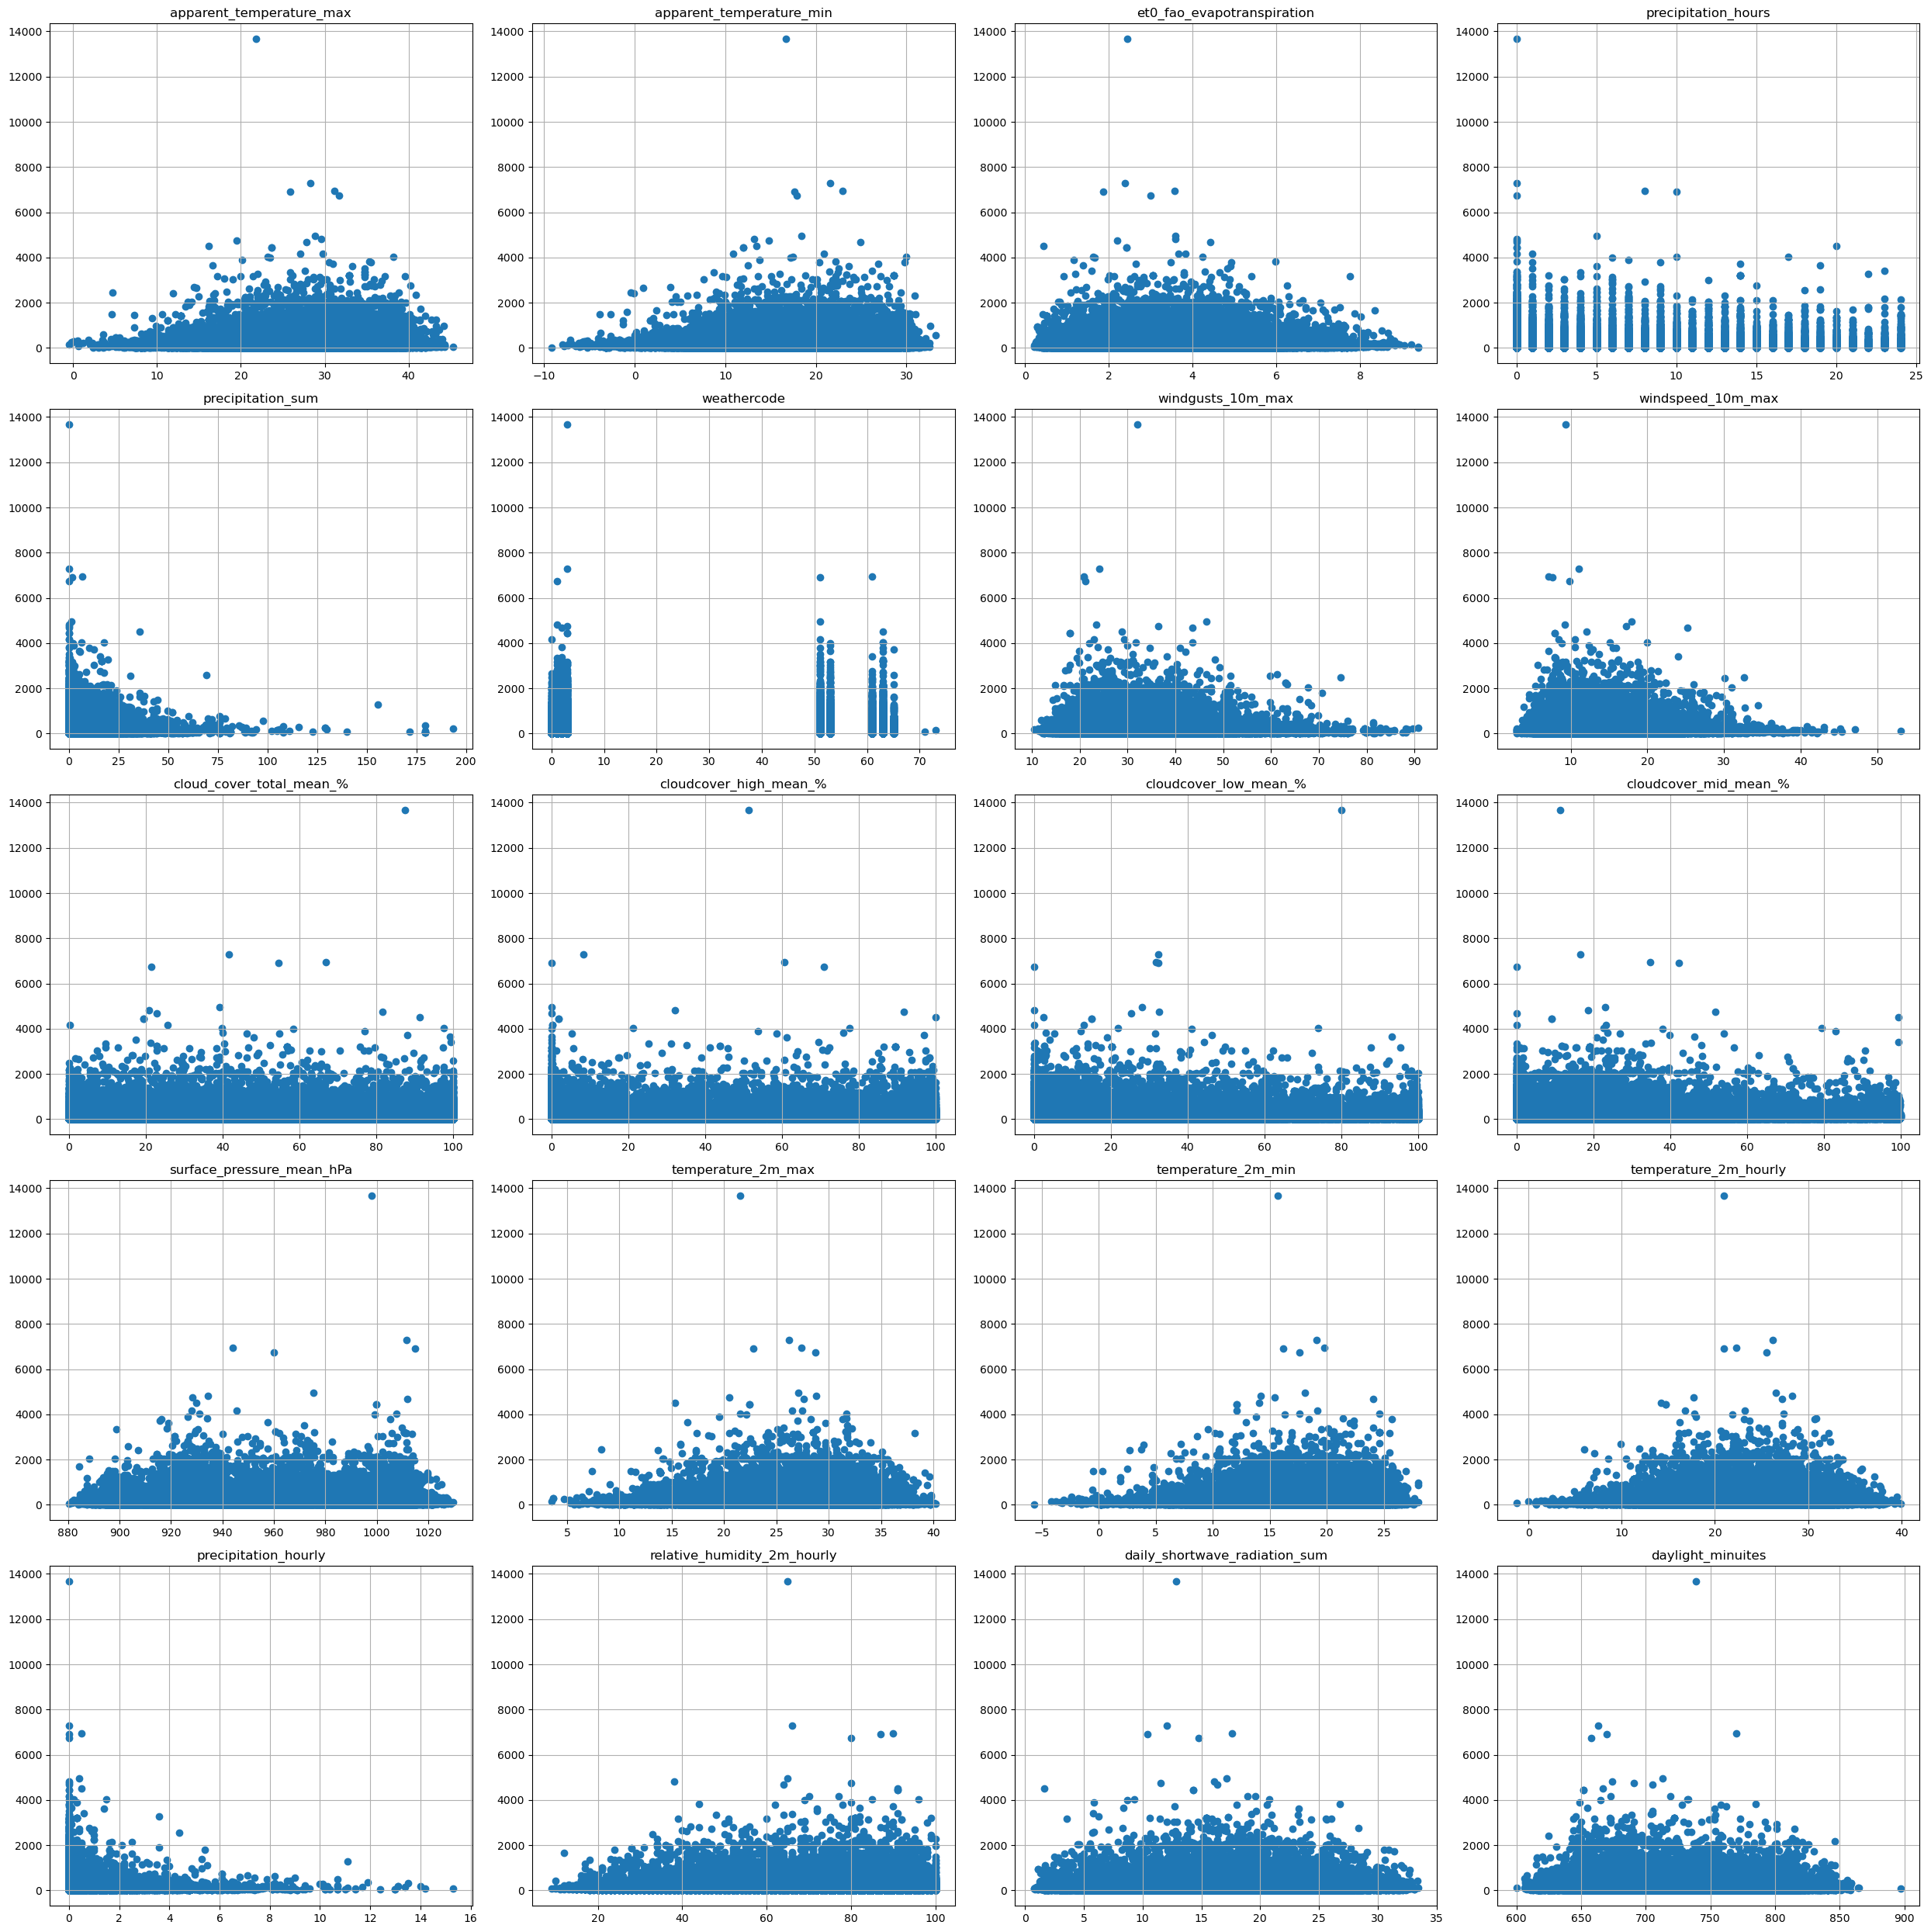

In [88]:
"""
Построим набор графиков зависимости продаж от погодных условий.
По графикам кажется, что покупатели предпочитают хорошую погоду, но не стоит
забывать, что речь идет о Бразилии, где бОльшую часть времени погода хоршая.
Если посмотреть внимательнее, то можно найти следующие взаимосвязи:
Чем дольше идет дождь - тем ниже стоимость покупок, но больше их общее кол-во
(т.е. дорогие покупки люди чаще делают в хорошую погоду, зато во время дождя чаще склонны
шопить по мелочи).
Ту же самую тенденцию можно видеть и при сильном ветре люди также более склонны заказывать товары онлайн.
Если сравнить число облачных дней и распределение покупок, видно, что люди предпочитают онлайн-шопинг в дни,
когда солнца мало или нет.
Если температура опускается ниже 20 градусов, больше людей предпочитают онлайн-покупки.
И, что неочевидно, более сухой воздух также благоприятен для шопинга. Вероятно это связано с
более низкой влажностью в зимние месяцы (как было сказано ранее, низкие температуры провоцируеют рост
онлайн-покупок)

"""
y = ys['payment_value']
data = X
ncols = 4
nrows = len(feauters)/ncols if len(feauters) % ncols == 0 else len(feauters)/ncols + 1
nrows = int(nrows)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
# print(nrows, ncols)
for i, column in enumerate(feauters):
    col = i % ncols
    row = int(i/ncols)
    # print(row, col)
    axis = axes[row, col]
    # data[column].plot(ax=axis, grid=True)
    axis.scatter(data[column], y)
    axis.grid(True)
    axis.set_title('{}'.format(column))
plt.tight_layout()

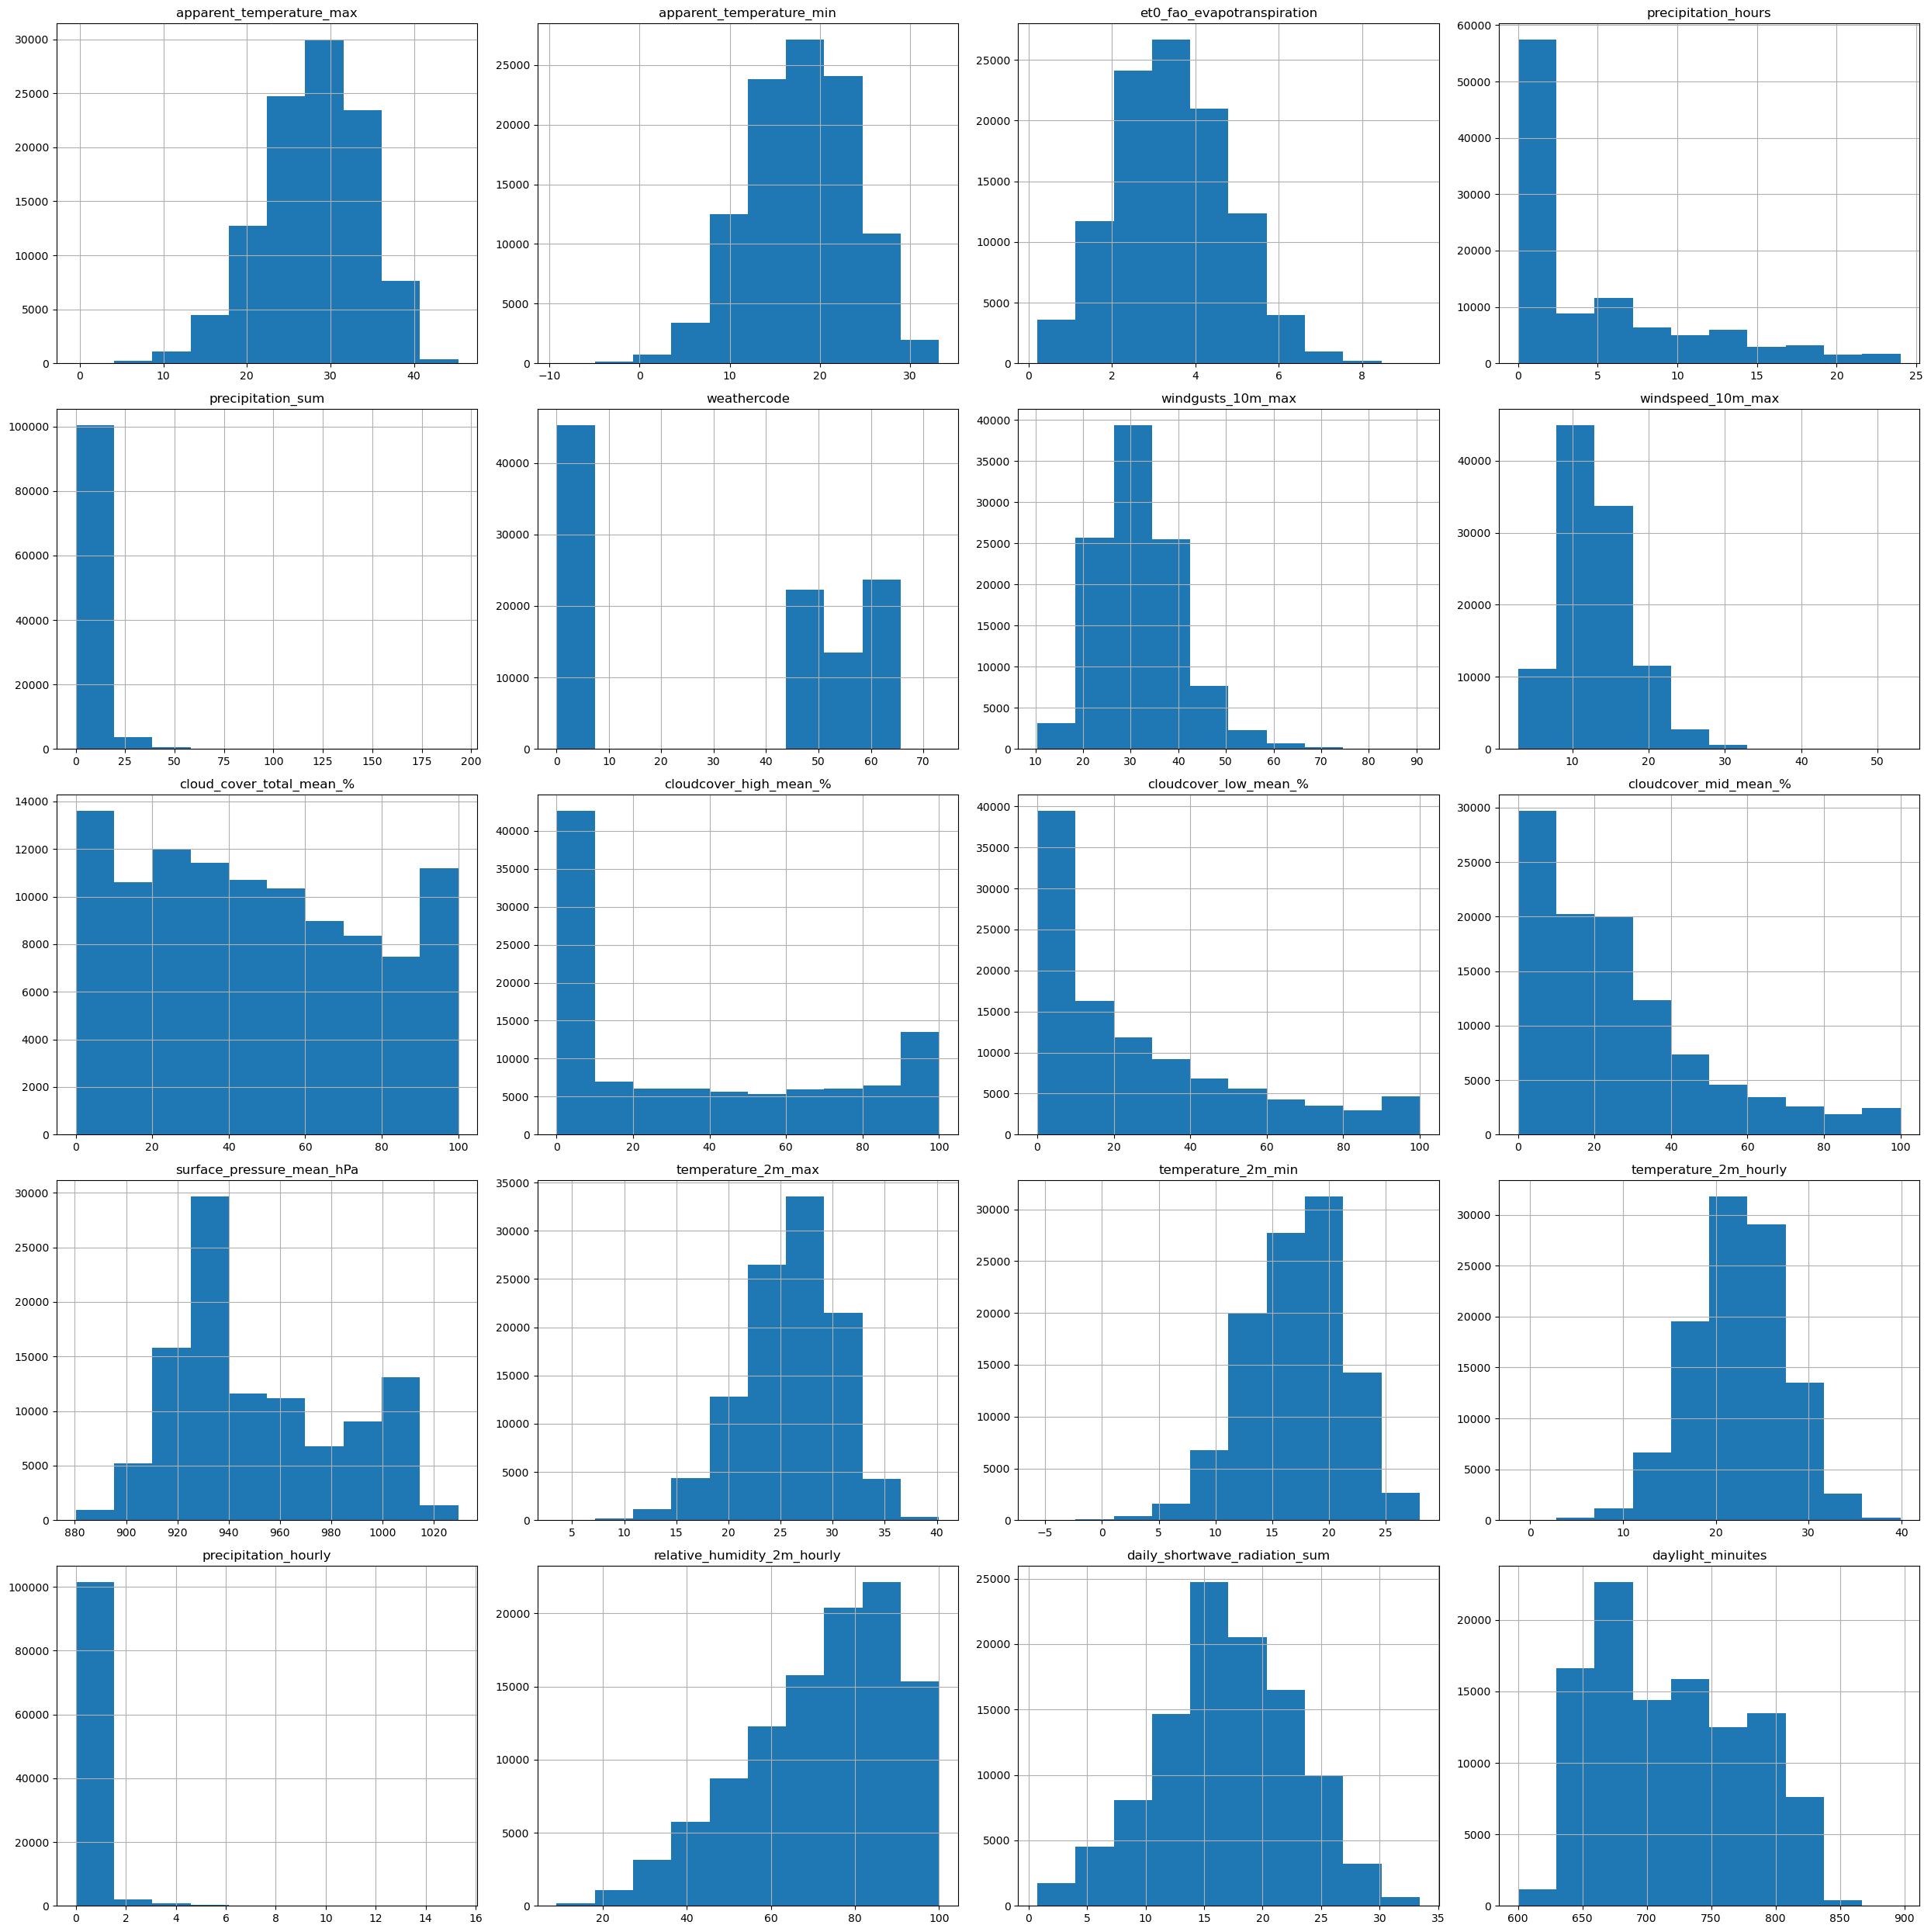

In [92]:
"""
Также построим гистограмы для сравнения общего распределения дней с различными погодными условиями
"""

data = X
ncols = 4
nrows = len(feauters)/ncols if len(feauters) % ncols == 0 else len(feauters)/ncols + 1
nrows = int(nrows)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
# print(nrows, ncols)
for i, column in enumerate(feauters):
    col = i % ncols
    row = int(i/ncols)
    # print(row, col)
    axis = axes[row, col]
    # data[column].plot(ax=axis, grid=True)
    axis.hist(data[column])
    axis.grid(True)
    axis.set_title('{}'.format(column))
plt.tight_layout()

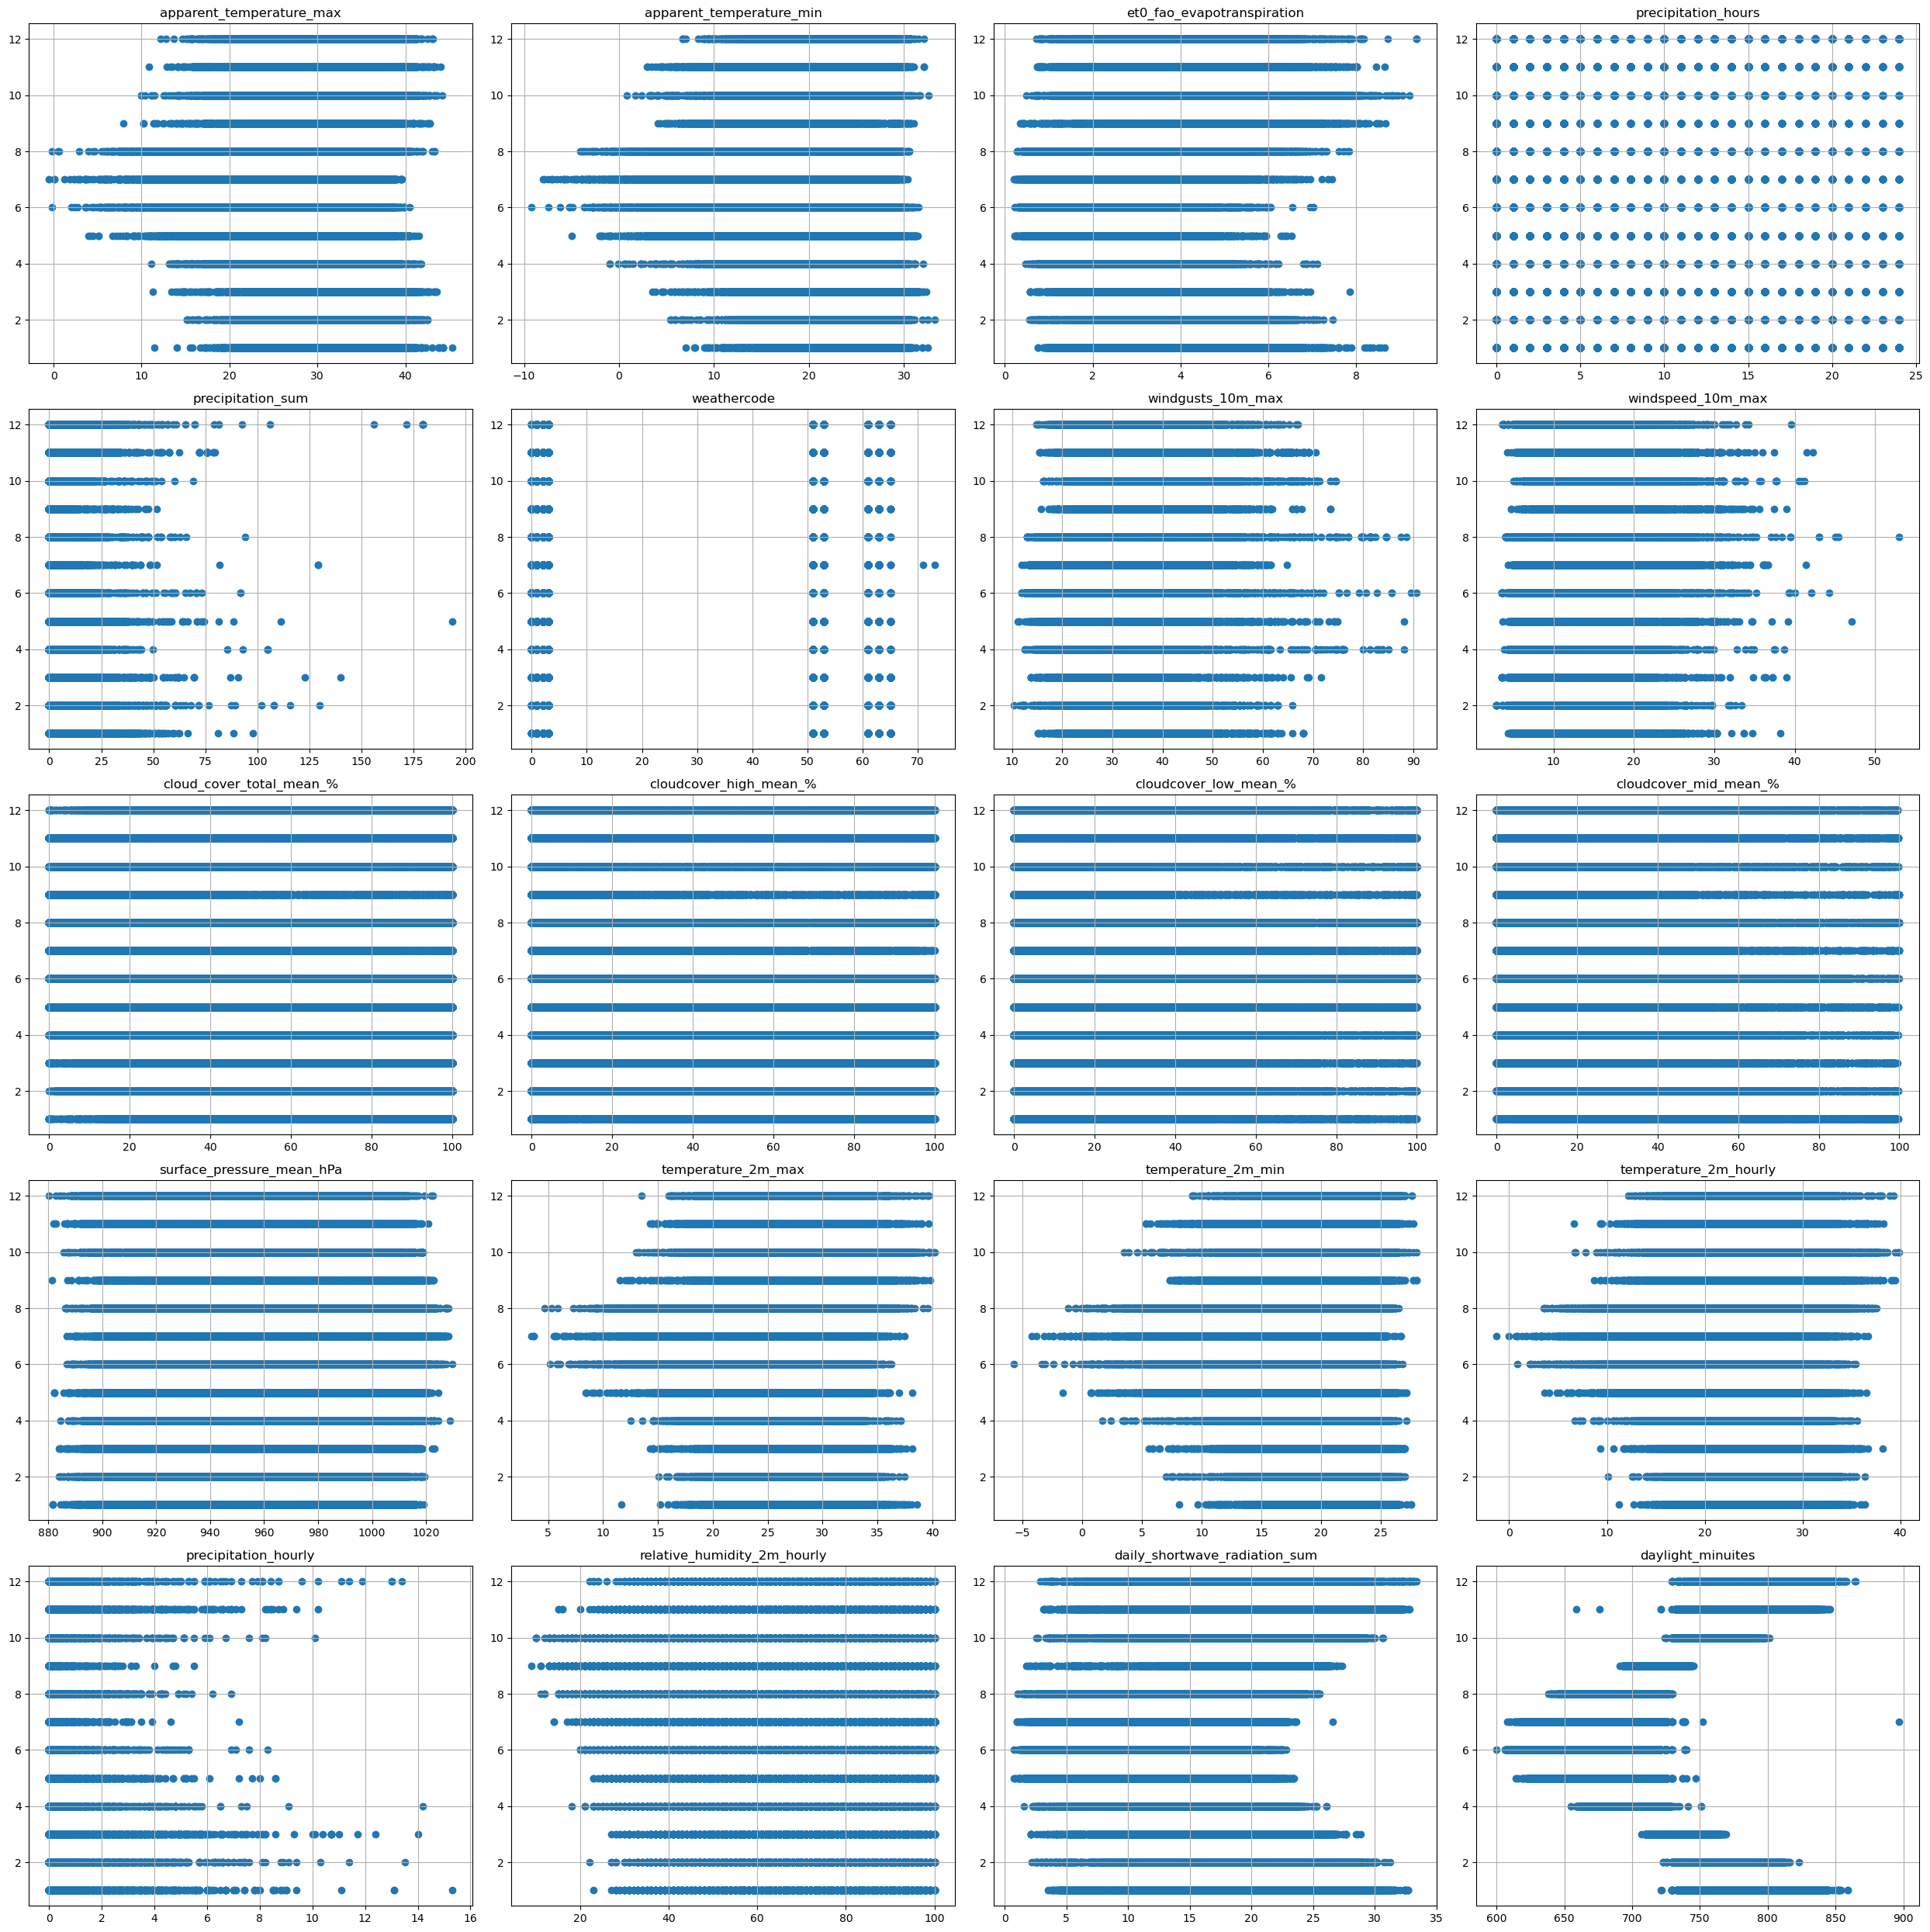

In [89]:
"""
Построим набор графиков зависимости погодных условий от месяца (полезно для поиска доп взаимосвязей)


"""
y = ys['month']
data = X
ncols = 4
nrows = len(feauters)/ncols if len(feauters) % ncols == 0 else len(feauters)/ncols + 1
nrows = int(nrows)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
# print(nrows, ncols)
for i, column in enumerate(feauters):
    col = i % ncols
    row = int(i/ncols)
    # print(row, col)
    axis = axes[row, col]
    # data[column].plot(ax=axis, grid=True)
    axis.scatter(data[column], y)
    axis.grid(True)
    axis.set_title('{}'.format(column))
plt.tight_layout()

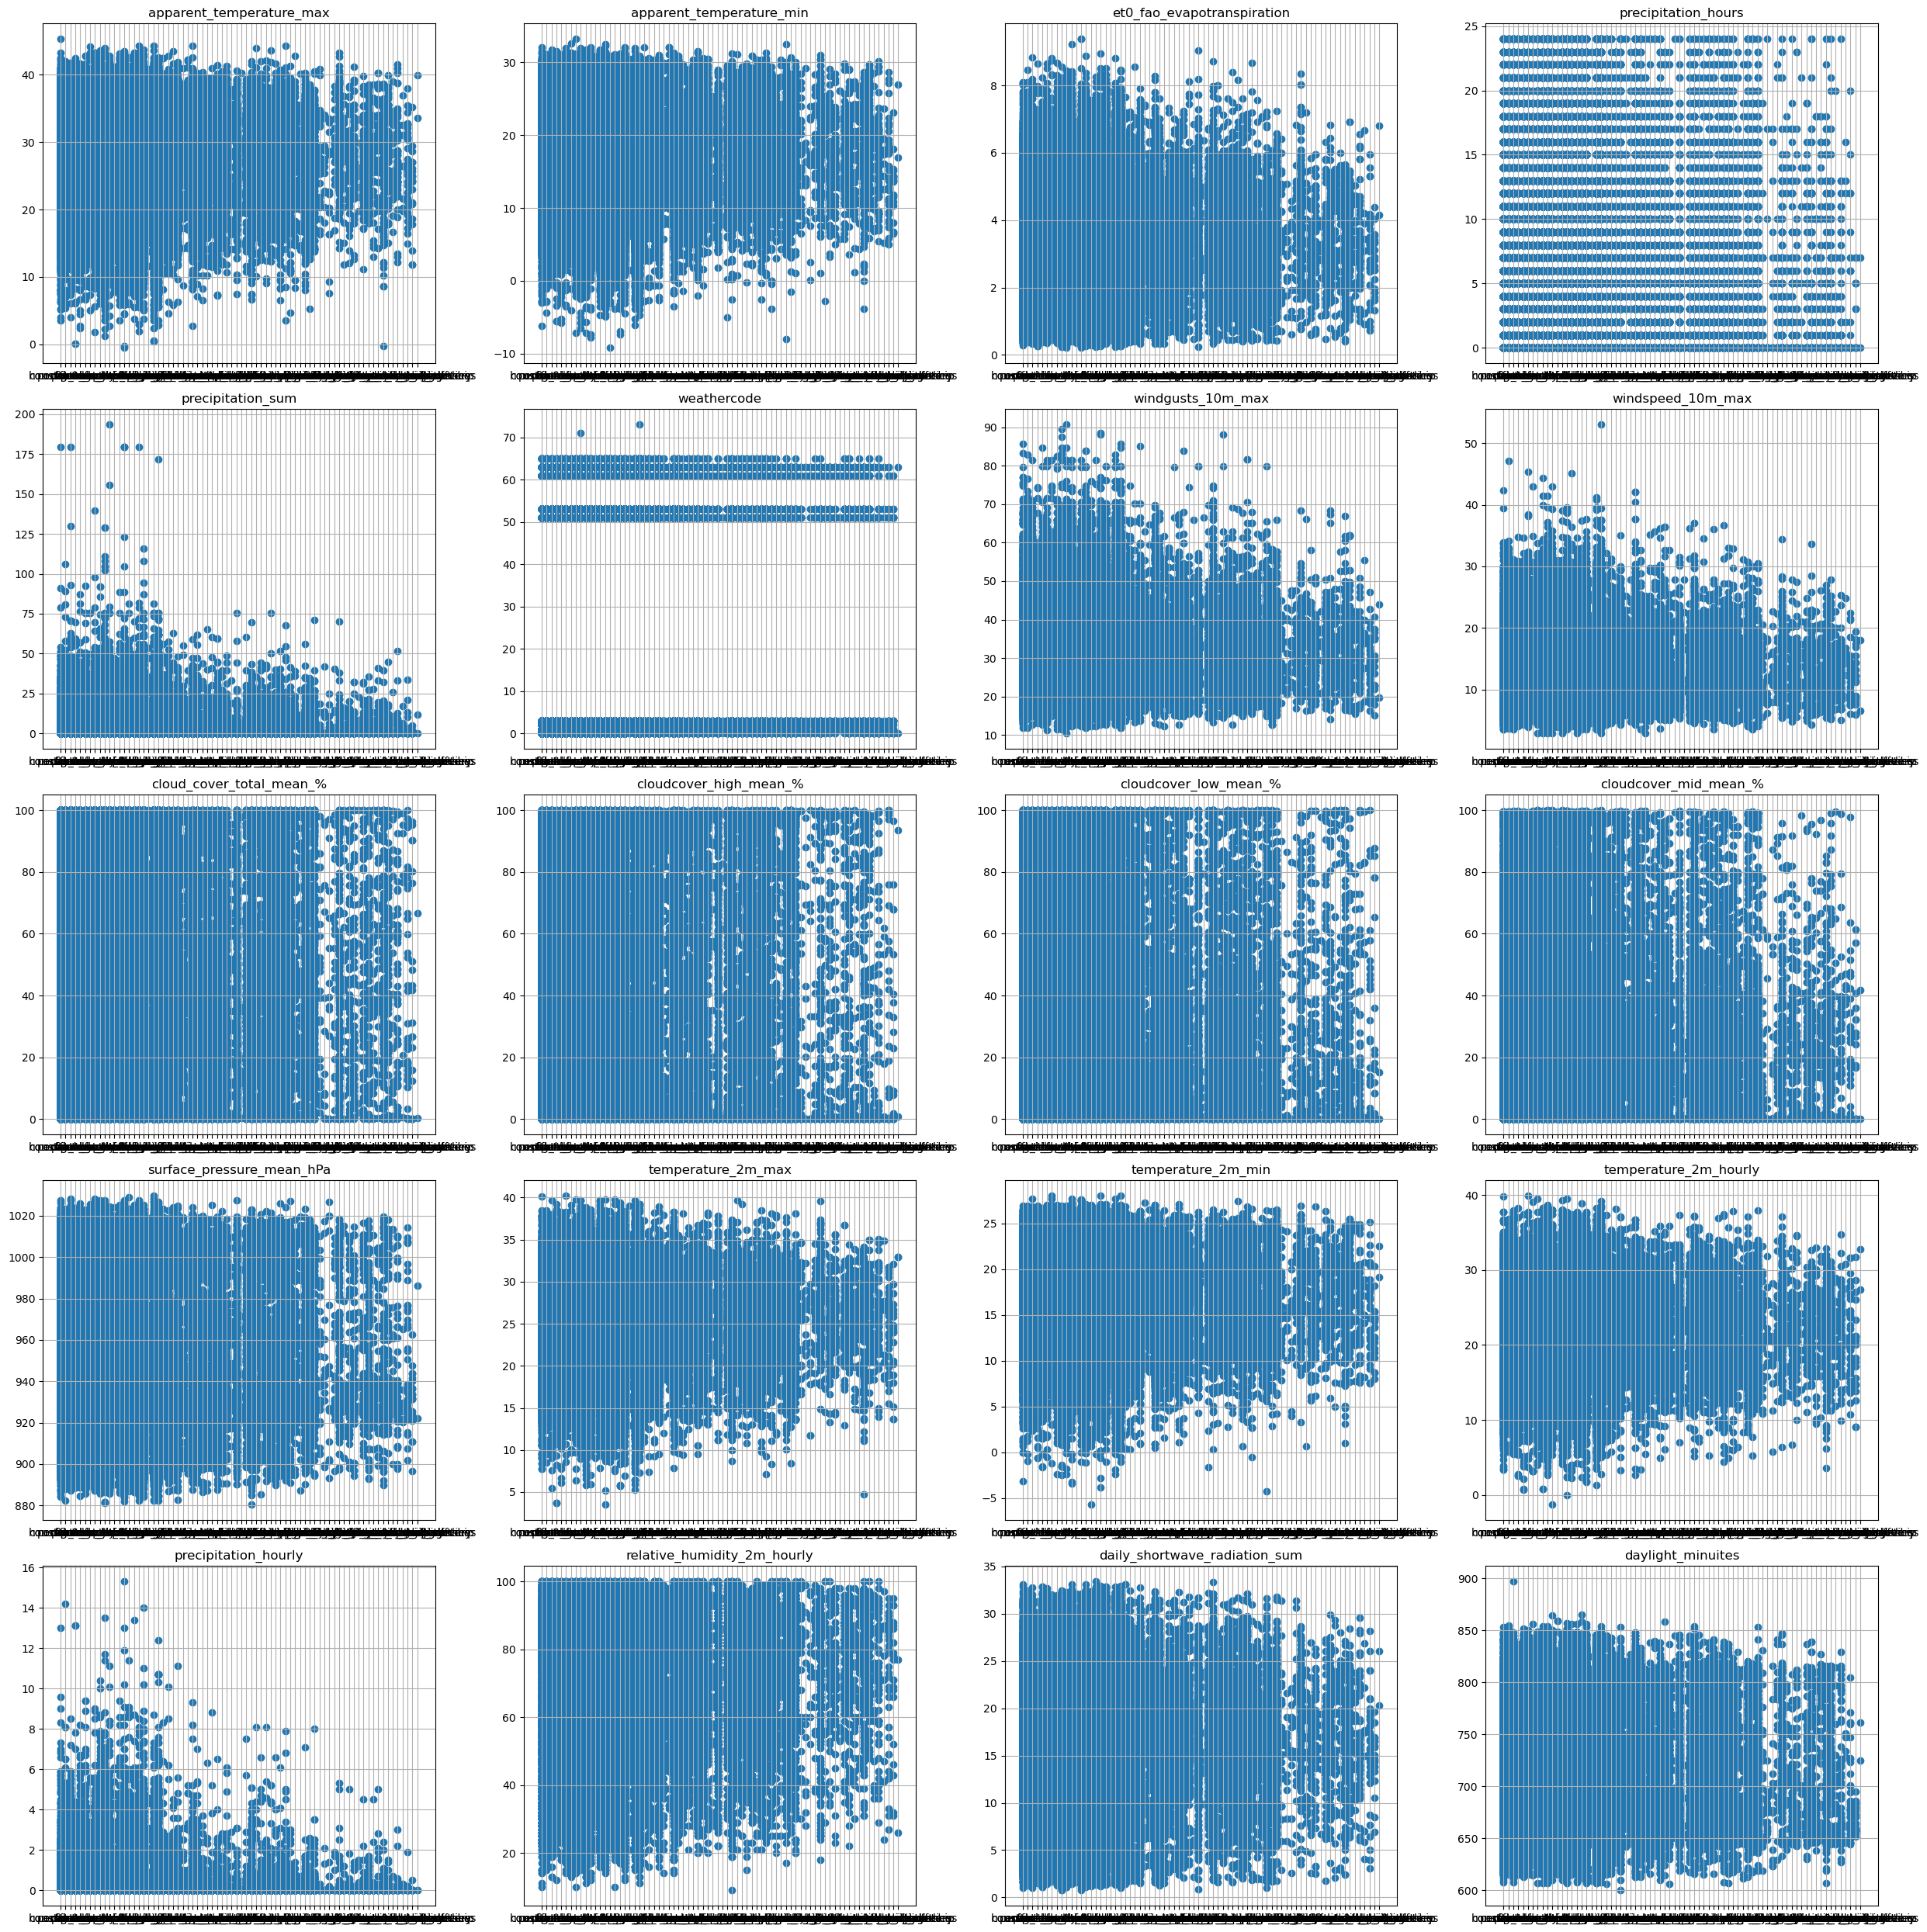

In [90]:
"""
Предпочтения в продуктовых категориях также зависят от погодных условий.
Возможен дополнительный анализ.
"""

y = ys['product_category']
data = X
ncols = 4
nrows = len(feauters)/ncols if len(feauters) % ncols == 0 else len(feauters)/ncols + 1
nrows = int(nrows)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
# print(nrows, ncols)
for i, column in enumerate(feauters):
    col = i % ncols
    row = int(i/ncols)
    # print(row, col)
    axis = axes[row, col]
    # data[column].plot(ax=axis, grid=True)
    axis.scatter(y, data[column])
    axis.grid(True)
    axis.set_title('{}'.format(column))
plt.tight_layout()